# Урок 7. Нестандартные ситуации

In [1]:
import numpy as np
#import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots

import scipy.stats as stats
from statsmodels.stats.power import tt_ind_solve_power, zt_ind_solve_power
from statsmodels.stats import proportion
from statsmodels.stats.meta_analysis import effectsize_smd

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## Задание 1
Мы провели A/A текст, в котором сравнили одну и ту же версию сайта. Полученные результаты выглядят следующим образом. Можем ли мы на основе проведенного A/A теста, запустить процесс A/B-тестирования? Используйте уровень доверия 95%.

Для оценки статистической значимости различий между конверсиями в двух группах будем использовать Z-критерий для разности долей:\
$Z = \cfrac{p_1 - p_2}{\sqrt{p (1-p) \left(\cfrac{1}{n_1} + \cfrac{1}{n_2}\right)}}$, где
$p = \cfrac{m_1 + m_2}{n_1 + n_2}$

На уровне значимости $\alpha = 0.05$ проверим гипотезу $H_0: p_1 = p_2$ о том, что выборки равноценны против конкурирующей гипотезы $H_1: p_1 < p_2$.

In [2]:
n1, n2, m1, m2, alpha = 1731, 1702, 152, 189, 0.05

In [3]:
p1, p2, p = m1/n1, m2/n2, (m1+m2)/(n1+n2)

Zk = stats.norm.ppf(1-alpha)
print(f'{Zk = :.2f}')

Zn = (p1-p2)/np.sqrt(p*(1-p)*(1/n1+1/n2))
print(f'{Zn = :.2f}')

print(f'H0: p1 = p2 is {Zn>-Zk}')

Zk = 1.64
Zn = -2.28
H0: p1 = p2 is False


На уровне значимости $\alpha=0.05$ гипотезу $H_0: p_1 = p_2$ отвергаем в пользу конкурирующей гипотезы $H_1: p_1 < p_2$. \
Система сплитования трафика работает плохо, A/B тест запускать нельзя.

In [4]:
# Генерируем распределение
A = stats.bernoulli.rvs(p=p1, size=n1, random_state=12)
B = stats.bernoulli.rvs(p=p2, size=n2, random_state=25)

Метрика качетсвенная (пропорция), поэтому используем Хи-квардат или Z-критерий долей.

In [5]:
# Сравнение Хи-квадрат и Z
chi_value, p_value_chi2, table = proportion.proportions_chisquare([A.sum(), B.sum()], [A.size, B.size])
z_value, p_value_z = proportion.proportions_ztest([A.sum(), B.sum()], [A.size, B.size])
print(p_value_chi2, p_value_z)

0.02286339922157709 0.02286339922157713


In [6]:
# Считаем статистику по выборкам
stat_value, p_value, table = proportion.proportions_chisquare([A.sum(), B.sum()], [A.size, B.size])

se = np.sqrt((p1 * (1 - p1) / A.size) + (p2 * (1 - p2) / B.size))
md = A.mean() - B.mean()
left = md - 1.96 * se
right = md + 1.96 * se

print(f"Mean difference: {np.round(md, 5)}, \
        p-value: {p_value} and confidence interval is: [{np.round(left, 5)}, {np.round(right, 5)}]")

if p_value < alpha and not min(left, right) < 0 < max(left, right):
    print(f"Sample #{1 if md > 0 else 2} mean is greater")
else:
    print("No significant difference")

Mean difference: -0.02324,         p-value: 0.02286339922157709 and confidence interval is: [-0.04325, -0.00322]
Sample #2 mean is greater


In [7]:
# Альтернативный способ через бутсрап
booted_diff = []
booted_pvalue = []
size = max(A.size, B.size)

for _ in tqdm(range(10_000)):
    As = stats.bernoulli.rvs(p=p1, size=size)
    Bs = stats.bernoulli.rvs(p=p2, size=size)
    booted_diff.append(np.mean(As - Bs))
    booted_pvalue.append(proportion.proportions_chisquare([As.sum(), Bs.sum()], [As.size, Bs.size])[1])

md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3954.14it/s]


In [8]:
# Доверительный интервал разниц между группами
print(f"Mean difference: {np.round(md_ci, 5)}, p-value: {p_value_ci} and confidence interval is: [{np.round(left_ci, 5)}, {np.round(right_ci, 5)}]")

if p_value_ci < alpha and not min(left_ci, right_ci) < 0 < max(left_ci, right_ci):
    print(f"Sample #{1 if md_ci > 0 else 2} mean is greater")
else:
    print("No significant difference")

Mean difference: -0.02317, p-value: 0.023726442671732295 and confidence interval is: [-0.04333, -0.00347]
Sample #2 mean is greater


In [ ]:
'''
fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Histogram(x=booted_pvalue, name='booted_pvalue',),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=booted_diff, name='booted_diff',),
    row=2, col=1
)

fig.update_layout(height=800, width=1000, title_text="After bootstrap")
fig.show()
'''

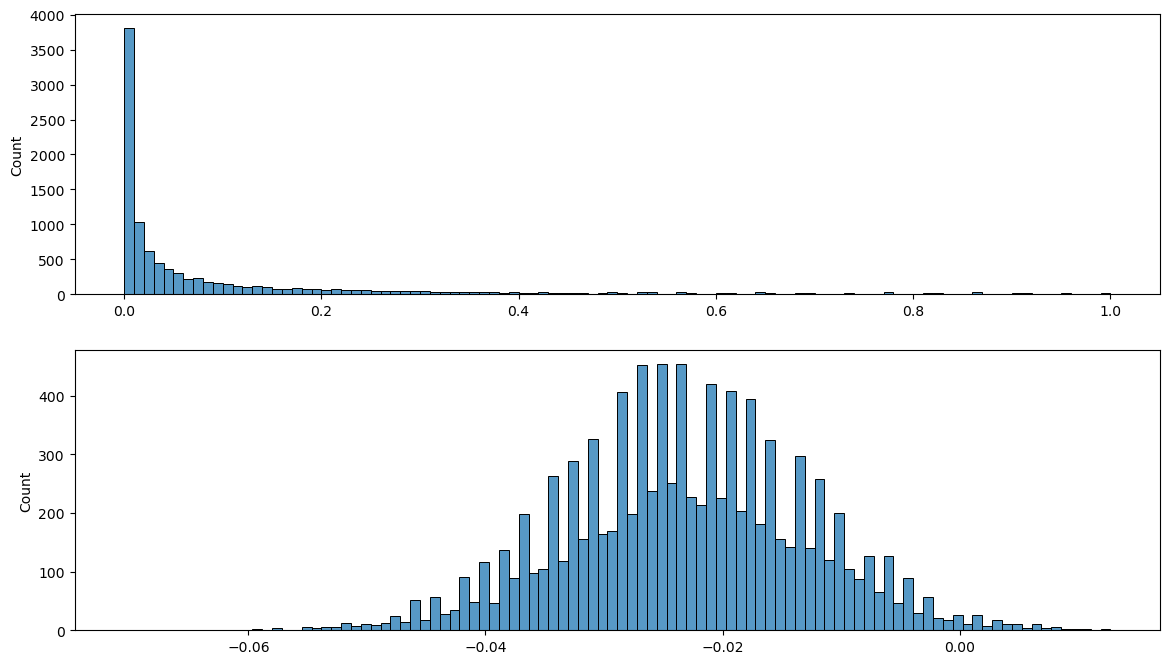

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(14, 4*2))

sns.histplot(booted_pvalue, bins=100, ax=ax[0])
sns.histplot(booted_diff, bins=100, ax=ax[1]);

In [10]:
# Ошибка первого рода, которая говорит нам о том, что группы различаются между собой!
np.mean(np.array(booted_pvalue) < 0.05) # FPR

0.6279

63% из бутстрапа показали разницу между средними.

Соответственно, если у нас значения p-value распределены таким образом (экспоненциально) значит выборки разные. Значит бывает разница между выборками на случайно сгенерированных (семплированных) данных, соответственно мы не можем их использовать в качестве результата A/A теста, потому что они некорректы.

0.6337 - ошибка I рода между двумя группами, т.е. в скольки процентах мы будем ошибаться, если примем $H_0$ о равенстве групп. Т.е. в 63% мы будем находить разницу между двумя группами.

## Задание 2
Мы провели A/A текст, в котором сравнили одну и ту же версию сайта. Полученные результаты выглядят следующим образом. Можем ли мы на основе проведенного A/A теста, запустить процесс A/B-тестирования? Используйте уровень доверия 95%.

$H_0: \bar{X} - \bar{Y} = 0$ \
$H_1: \bar{X} - \bar{Y} > 0$ – правосторонняя критическая область

Для проверки нулевой гипотезы используют статистический критерий \
$Z = \cfrac{\bar{x}-\bar{y}}{\sqrt{\cfrac{D_x^2}{n}+\cfrac{D_y^2}{m}}}$, где \
$\bar{x}$, $\bar{y}$ - выборочные средние \
$D_x^2$, $D_y^2$ - смещенные выборочные дисперсии (можно использовать и несмещенную)

Правосторонняя критическая область. Если $z_н < z_к$, то гипотеза $H_0$ принимается, в случае $z_н > z_к$ – отвергается.

In [11]:
Mx, SDx, Nx = 38.175, 28, 1080 #A
My, SDy, Ny = 37.710, 11, 1050 #B
alpha = 0.05

In [12]:
Zk = stats.norm.ppf(1-alpha)
print(f'Zk = {Zk:.2f}')

Zn = (Mx-My)/np.sqrt(SDx**2/Nx + SDy**2/Ny)
print(f'Zn = {Zn:.2f}')

print(f'H0: M(X)=M(Y) is {Zn<Zk}')

Zk = 1.64
Zn = 0.51
H0: M(X)=M(Y) is True


In [13]:
# Генерируем нормальное распределение на основе введенных данных
A = stats.norm(loc=Mx, scale=SDx).rvs(size=Nx, random_state=42)
B = stats.norm(loc=My, scale=SDy).rvs(size=Ny, random_state=42)

In [ ]:
'''
fig = go.Figure()
fig.add_trace(go.Histogram(x=norm_1, name='norm_1'))
fig.add_trace(go.Histogram(x=norm_2, name='norm_2'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.5)
fig.show()
'''

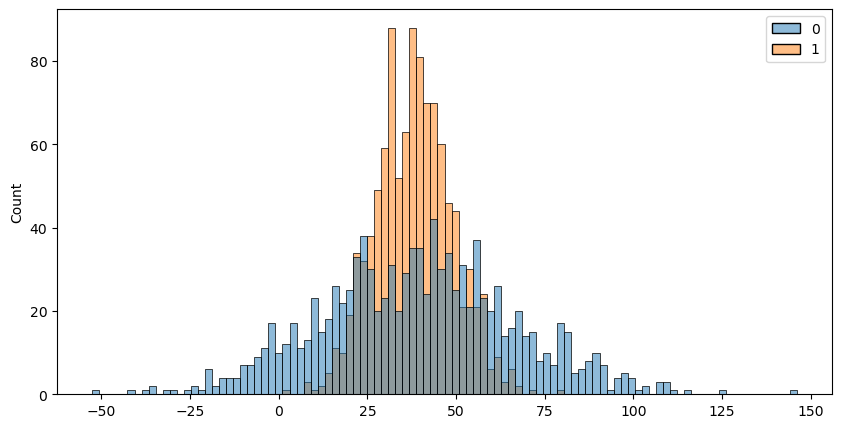

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot([A,B], bins=100);

In [15]:
# Считаем статистику по выборкам
stat_value, p_value = stats.ttest_ind(A, B, equal_var=False, alternative='two-sided')
md = A.mean() - B.mean()
se = md / stat_value

left, right = stats.norm.interval(.95, loc=md, scale=se)
print(f"Mean difference: {md:.5f}, p-value: {p_value} and confidence interval is: [{left:.5f}, {right:.5f}]")

if p_value < alpha and not min(left, right) < 0 < max(left, right):
    print(f"Sample #{1 if md > 0 else 2} mean is greater")
else:
    print("No significant difference")

Mean difference: 0.92076, p-value: 0.30594550751631316 and confidence interval is: [-0.84136, 2.68287]
No significant difference


In [16]:
# Альтернативный способ через бутсрап
booted_diff = []
booted_pvalue = []
size = max(A.size, B.size)

for _ in tqdm(range(10_000)):
    As = np.random.choice(A, size=size, replace=True)
    Bs = np.random.choice(B, size=size, replace=True)
    booted_diff.append(np.mean(As - Bs))
    booted_pvalue.append(stats.ttest_ind(As, Bs, equal_var=False, alternative='two-sided')[1])

# Доверительный интервал разниц между группами
md, std = np.mean(booted_diff), np.std(booted_diff, ddof=1)
left, right = np.percentile(booted_diff, [2.5, 97.5])
p_value = 2 * (1 - stats.norm.cdf(np.abs(md / std)))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4354.02it/s]


In [17]:
print(f"Mean difference: {md:.5f}, p-value: {p_value} and confidence interval is: [{left:.5f}, {right:.5f}]")

if p_value < alpha and not min(left,right) < 0 < max(left,right):
    print(f"Sample #{1 if md > 0 else 2} mean is greater")
else:
    print("No significant difference")

Mean difference: 0.91637, p-value: 0.3142640944677684 and confidence interval is: [-0.87261, 2.71633]
No significant difference


In [18]:
# Ошибка первого рода, которая говорит нам о том, что группы почти не различаются между собой!
np.mean(np.array(booted_pvalue) < 0.05) # FPR

0.1774

In [ ]:
'''
fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Histogram(x=booted_pvalue, name='booted_pvalue',),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=booted_diff, name='booted_diff',),
    row=2, col=1
)

fig.update_layout(height=800, width=1000, title_text="After bootstrap")
fig.show()
'''

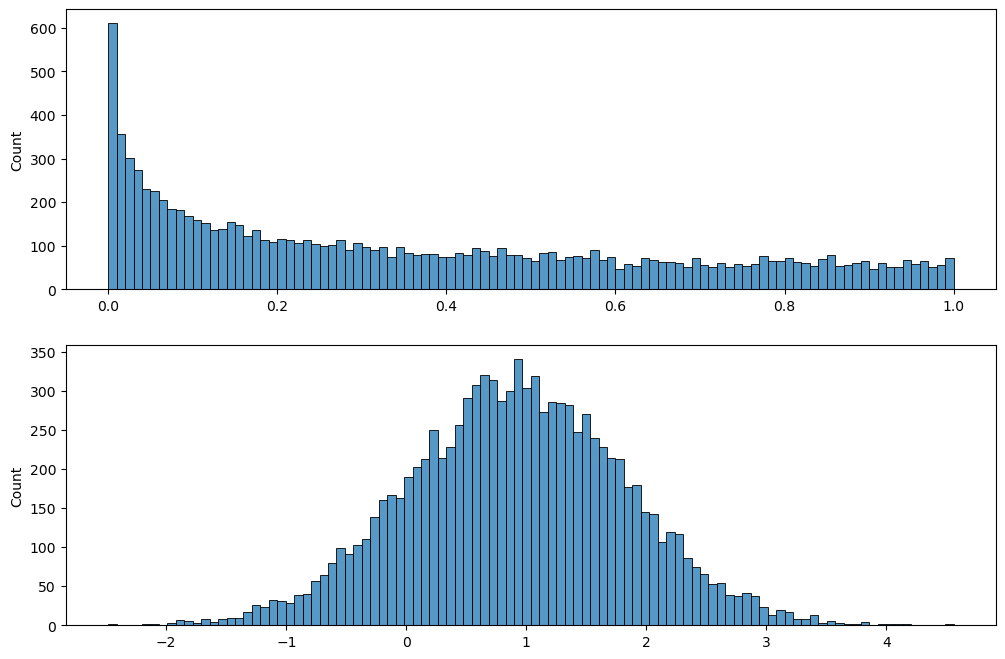

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 4*2))

sns.histplot(booted_pvalue, bins=100, ax=ax[0])
sns.histplot(booted_diff, bins=100, ax=ax[1]);

В 20% случаях мы нашли разницу между группами и в 80% случаев - не нашли.

Идеальный случай, когда ошибка I рода (FPR) 5% мы получаем равномерное распределение.\
Мы получили почти равномерное распределение с явным выбросом слева. Поэтому на основе полученного FPR мы не можем однозначно сказать, что группы не равны.

## Задание 3
Мы запустили A/B-тест. На его проведение мы собираемся потратить 1 неделю, на каждую выборку направить по 10000 юзеров. На третий день, продакт посмотрел на промежуточные результаты. На этот момент в каждой выборке было по 3000 юзеров, а результат в конверсиях был статистически значимым в пользу версии B. Можем ли мы на основе таких данных выпустить версию B на всех юзеров?

Нет.

## Задание 4
Мы провели A/B-тест, в котором изменили элементы после добавления товара в корзину. То есть, юзеры видят разные версии сайта после того, как что-то добавят в корзину. Получили следующие результаты. Какую версию вы в итоге выберите?

|  | A | B |
|---|---|---|
| Посещение | 6351 | 6442 |
| Добавление в корзину | 1754 | 1902 |
| Подтверждение заказа | 1025 | 1099 |
| Транзакция | 623 | 642 |

In [20]:
alpha = .05

### Конверсия из "Посещение" в "Добавление в корзину"

In [21]:
Nx, Ny = 6351, 6442
p1, p2 = 1754 / Nx, 1902 / Ny

In [22]:
# Генерируем распределение
A = stats.bernoulli.rvs(p=p1, size=Nx, random_state=12)
B = stats.bernoulli.rvs(p=p2, size=Ny, random_state=25)

In [23]:
# Альтернативный способ через бутсрап
booted_diff = []
booted_pvalue = []
size = max(A.size, B.size)

for _ in tqdm(range(10_000)):
    As = stats.bernoulli.rvs(p=p1, size=size)
    Bs = stats.bernoulli.rvs(p=p2, size=size)
    booted_diff.append(np.mean(As - Bs))
    booted_pvalue.append(proportion.proportions_chisquare([As.sum(), Bs.sum()], [As.size, Bs.size])[1])

md, std = np.mean(booted_diff), np.std(booted_diff, ddof=1)
left, right = np.percentile(booted_diff, [2.5, 97.5])
p_value = 2 * (1 - stats.norm.cdf(np.abs(md / std)))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2515.64it/s]


In [24]:
print(f"Mean difference: {md:.5f}, p-value: {p_value} and confidence interval is: [{left:.5f}, {right:.5f}]")

if p_value < alpha and not min(left,right) < 0 < max(left, right):
    print(f"Sample #{1 if md > 0 else 2} mean is greater")
else:
    print("No significant difference")

Mean difference: -0.01916, p-value: 0.015470473426674403 and confidence interval is: [-0.03462, -0.00373]
Sample #2 mean is greater


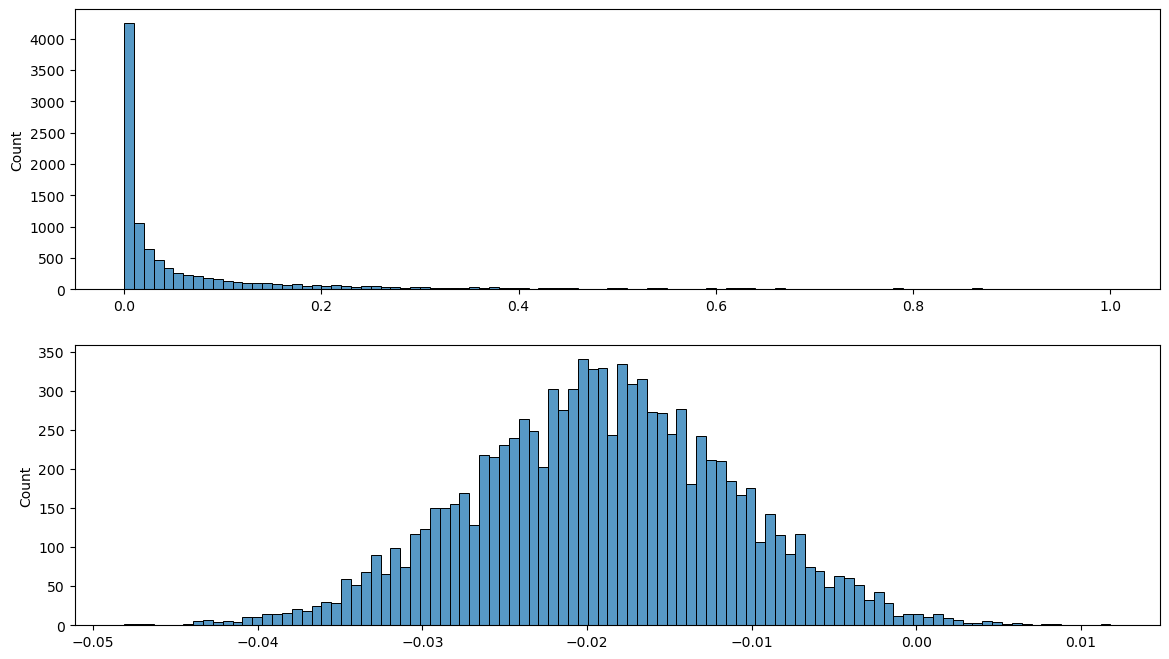

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(14, 4*2))

sns.histplot(booted_pvalue, bins=100, ax=ax[0])
sns.histplot(booted_diff, bins=100, ax=ax[1]);

In [26]:
# Ошибка первого рода (FPR)
np.mean(np.array(booted_pvalue) < 0.05)

0.6769

Т.к. коверсия в группах разная при одинаковом сайте (различия после добавления товара в корзину), то скорее всего проблемы с системой сплитования трафика.

### Конверсия из "Добавление в корзину" в "Подтверждение заказа"

In [27]:
Nx, Ny = 1754, 1902
p1, p2 = 1025 / Nx, 1099 / Ny

In [28]:
# Генерируем распределение
A = stats.bernoulli.rvs(p=p1, size=Nx, random_state=12)
B = stats.bernoulli.rvs(p=p2, size=Ny, random_state=25)

In [29]:
# Альтернативный способ через бутсрап
booted_diff = []
booted_pvalue = []
size = max(A.size, B.size)

for _ in tqdm(range(10_000)):
    As = stats.bernoulli.rvs(p=p1, size=size)
    Bs = stats.bernoulli.rvs(p=p2, size=size)
    booted_diff.append(np.mean(As - Bs))
    booted_pvalue.append(proportion.proportions_chisquare([As.sum(), Bs.sum()], [As.size, Bs.size])[1])

md, std = np.mean(booted_diff), np.std(booted_diff, ddof=1)
left, right = np.percentile(booted_diff, [2.5, 97.5])
p_value = 2 * (1 - stats.norm.cdf(np.abs(md / std)))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3584.34it/s]


In [30]:
print(f"Mean difference: {md:.5f}, p-value: {p_value} and confidence interval is: [{left:.5f}, {right:.5f}]")

if p_value < alpha and not min(left,right) < 0 < max(left, right):
    print(f"Sample #{1 if md > 0 else 2} mean is greater")
else:
    print("No significant difference")

Mean difference: 0.00633, p-value: 0.6922450029611946 and confidence interval is: [-0.02524, 0.03785]
No significant difference


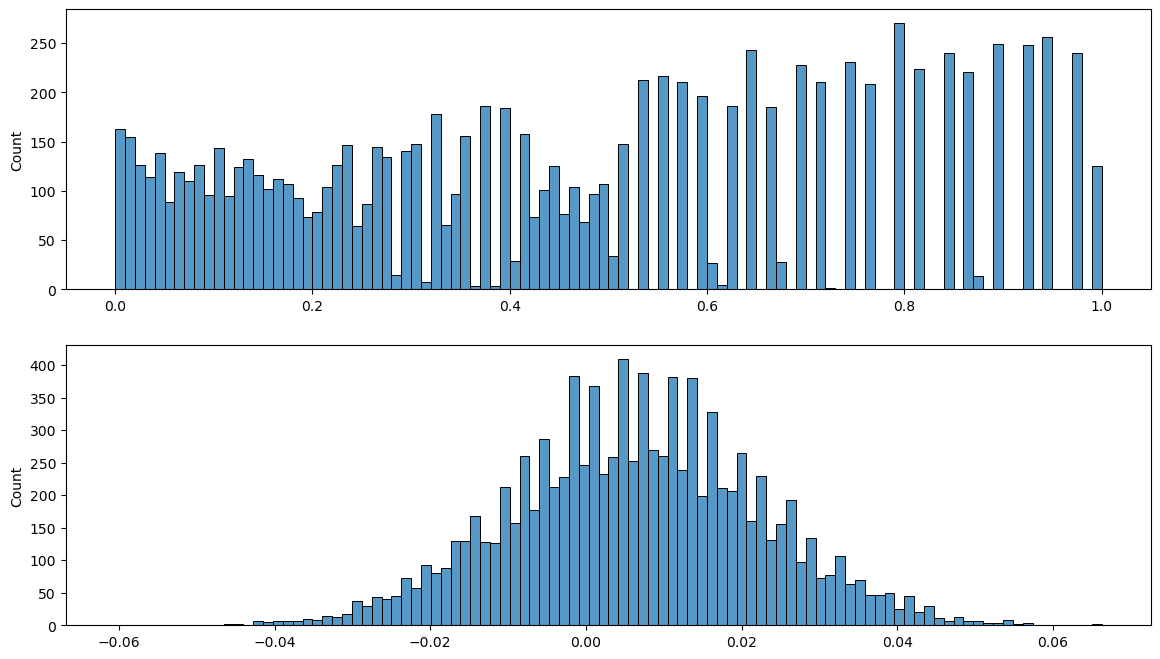

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(14, 4*2))

sns.histplot(booted_pvalue, bins=100, ax=ax[0])
sns.histplot(booted_diff, bins=100, ax=ax[1]);

In [32]:
# Ошибка первого рода (FPR)
np.mean(np.array(booted_pvalue) < 0.05)

0.0696

### Сквозная конверсия из "Добавление в корзину" в "Транзакция"

In [33]:
p1, p2 = 623 / Nx, 642 / Ny

In [34]:
# Генерируем распределение
A = stats.bernoulli.rvs(p=p1, size=Nx, random_state=12)
B = stats.bernoulli.rvs(p=p2, size=Ny, random_state=25)

In [35]:
# Альтернативный способ через бутсрап
booted_diff = []
booted_pvalue = []
size = max(A.size, B.size)

for _ in tqdm(range(10_000)):
    As = stats.bernoulli.rvs(p=p1, size=size)
    Bs = stats.bernoulli.rvs(p=p2, size=size)
    booted_diff.append(np.mean(As - Bs))
    booted_pvalue.append(proportion.proportions_chisquare([As.sum(), Bs.sum()], [As.size, Bs.size])[1])

md, std = np.mean(booted_diff), np.std(booted_diff, ddof=1)
left, right = np.percentile(booted_diff, [2.5, 97.5])
p_value = 2 * (1 - stats.norm.cdf(np.abs(md / std)))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3594.68it/s]


In [36]:
print(f"Mean difference: {md:.5f}, p-value: {p_value} and confidence interval is: [{left:.5f}, {right:.5f}]")

if p_value < alpha and not min(left,right) < 0 < max(left, right):
    print(f"Sample #{1 if md > 0 else 2} mean is greater")
else:
    print("No significant difference")

Mean difference: 0.01746, p-value: 0.2621399957830066 and confidence interval is: [-0.01314, 0.04784]
No significant difference


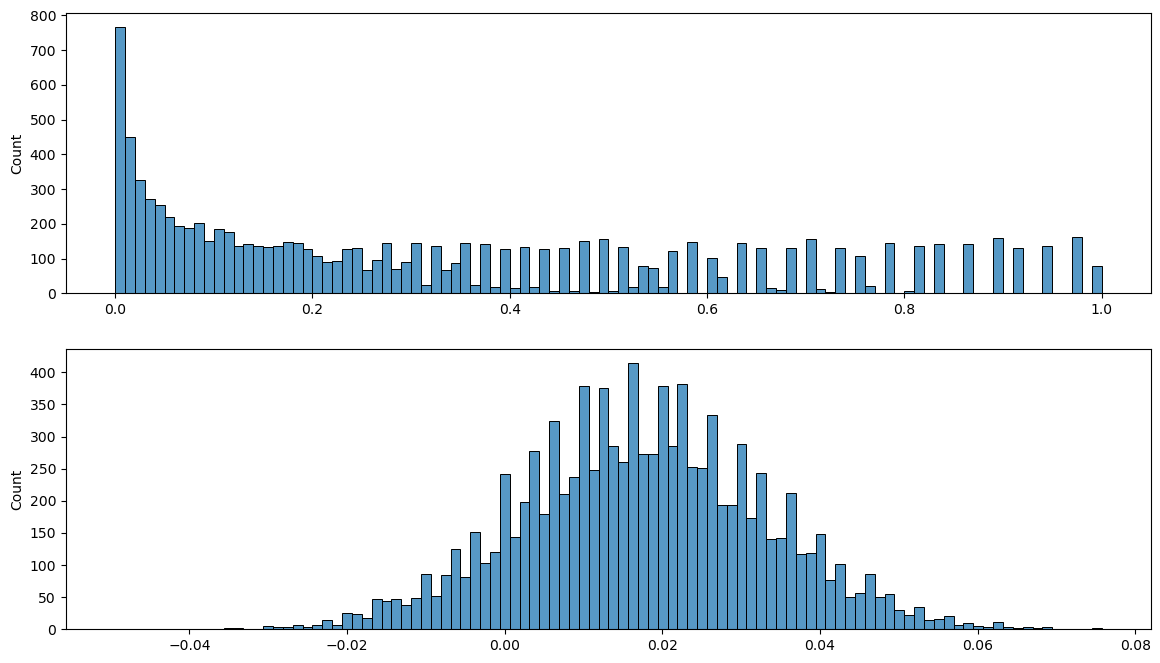

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(14, 4*2))

sns.histplot(booted_pvalue, bins=100, ax=ax[0])
sns.histplot(booted_diff, bins=100, ax=ax[1]);

In [38]:
# Ошибка первого рода (FPR)
np.mean(np.array(booted_pvalue) < 0.05)

0.2071

### Конверсия из "Подтверждение заказа" в "Транзакция"

In [39]:
Nx, Ny = 1025, 1099
p1, p2 = 623 / Nx, 642 / Ny

In [40]:
# Генерируем распределение
A = stats.bernoulli.rvs(p=p1, size=Nx, random_state=12)
B = stats.bernoulli.rvs(p=p2, size=Ny, random_state=25)

In [41]:
# Альтернативный способ через бутсрап
booted_diff = []
booted_pvalue = []
size = max(A.size, B.size)

for _ in tqdm(range(10_000)):
    As = stats.bernoulli.rvs(p=p1, size=size)
    Bs = stats.bernoulli.rvs(p=p2, size=size)
    booted_diff.append(np.mean(As - Bs))
    booted_pvalue.append(proportion.proportions_chisquare([As.sum(), Bs.sum()], [As.size, Bs.size])[1])

md, std = np.mean(booted_diff), np.std(booted_diff, ddof=1)
left, right = np.percentile(booted_diff, [2.5, 97.5])
p_value = 2 * (1 - stats.norm.cdf(np.abs(md / std)))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3954.25it/s]


In [42]:
print(f"Mean difference: {md:.5f}, p-value: {p_value} and confidence interval is: [{left:.5f}, {right:.5f}]")

if p_value < alpha and not min(left,right) < 0 < max(left, right):
    print(f"Sample #{1 if md > 0 else 2} mean is greater")
else:
    print("No significant difference")

Mean difference: 0.02338, p-value: 0.2649286909483717 and confidence interval is: [-0.01729, 0.06460]
No significant difference


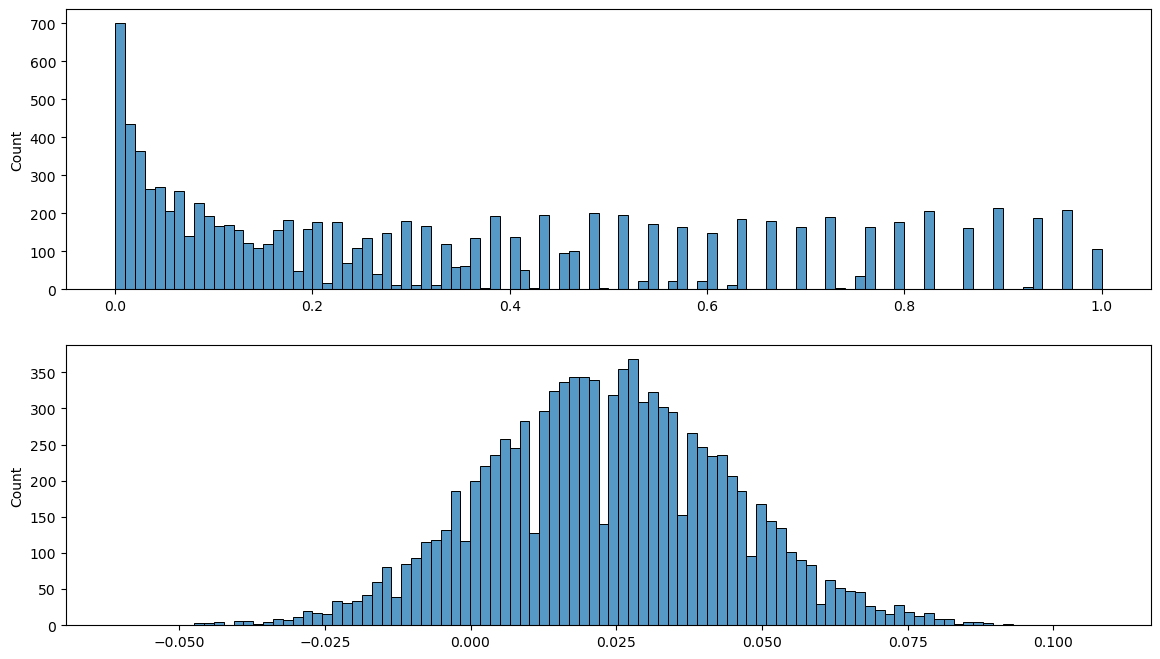

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(14, 4*2))

sns.histplot(booted_pvalue, bins=100, ax=ax[0])
sns.histplot(booted_diff, bins=100, ax=ax[1]);

In [44]:
# Ошибка первого рода (FPR)
np.mean(np.array(booted_pvalue) < 0.05)

0.2031